In [47]:
# """
# predicting a sequence of future prices (`n_steps_out`) instead of just one.

# Benefits of This Approach
# Utilizes Temporal Patterns: The model learns dependencies across multiple future time steps.
# More Robust Predictions: Predicting a sequence captures trends better than single-step predictions.
# Real-World Applicability: Multi-step forecasting is closer to real-world use cases, such as portfolio management.
# """

time: 312 µs (started: 2024-11-18 13:12:01 +00:00)


In [48]:
!pip install -r requirements.txt -q
!pip install ipython-autotime -q

time: 4.83 s (started: 2024-11-18 13:12:01 +00:00)


In [49]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import math
import matplotlib.pyplot as plt
import joblib
from joblib import Parallel, delayed
from pathlib import Path

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.layers import Input, Dense, Dropout, BatchNormalization, Reshape, Flatten, Bidirectional, LSTM
from keras.models import Model, Sequential
from keras.optimizers import Adam

%matplotlib inline
%load_ext autotime

print("tensorflow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
tensorflow version: 2.15.0
Num GPUs Available:  1


True

time: 4.44 ms (started: 2024-11-18 13:12:06 +00:00)


In [50]:
# parameter
# n_steps_in: Number of input time steps
# n_steps_out: Number of days to predict ahead

n_steps_in = 14  
n_steps_out = 5
epochs = 100
batch_size = 32

time: 369 µs (started: 2024-11-18 13:12:06 +00:00)


In [51]:
def load_processed_data(data_dir='processed_data'):
    """
    Load processed DataFrames list and numpy arrays from files
    """
    data_path = Path(data_dir)
    
    # Load list of DataFrames
    with open(data_path / 'processed_dfs.pkl', 'rb') as f:
        processed_dfs = joblib.load(f)
    
    # Load numpy arrays
    values_path = data_path / 'values_array.npy'
    values_list = np.load(values_path, allow_pickle=True)
    
    return processed_dfs, values_list

processed_dfs, values_list = load_processed_data('processed_data')
processed_dfs[0]

Price,Adj Close,Close,High,Low,Open,Volume,RSI,WR,SMA7,SMA14,...,EMA7,EMA25,EMA99,EMA200,MACD,CCI,Upper Band,Lower Band,Ulcer Index,Close Next Day
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2015-08-19 00:00:00+00:00,25.937435,28.752501,29.129999,28.670000,29.025000,193146000,38.868505,-58.647164,28.875357,29.083214,...,29.011843,29.811806,30.819353,30.361521,-0.639367,-59.662038,30.115768,28.050661,8.949397,28.162500
2015-08-20 00:00:00+00:00,25.405201,28.162500,28.587500,27.907499,28.520000,274006400,34.842467,-76.661486,28.845357,28.928750,...,28.799508,29.684936,30.766216,30.339640,-0.675706,-101.719165,29.807586,28.049914,8.822285,26.440001
2015-08-21 00:00:00+00:00,23.851353,26.440001,27.975000,26.412500,27.607500,513102000,26.282999,-99.232910,28.506786,28.702321,...,28.209631,29.435326,30.679692,30.300837,-0.833884,-193.641185,30.187027,27.217616,8.940749,25.780001
2015-08-24 00:00:00+00:00,23.255964,25.780001,27.200001,23.000000,23.717501,648825200,23.863926,-60.271513,28.077143,28.496607,...,27.602223,29.154147,30.581698,30.255854,-1.000959,-286.791374,30.611922,26.381293,9.012688,25.934999
2015-08-25 00:00:00+00:00,23.395788,25.934999,27.777500,25.875000,27.777500,414406400,25.595895,-58.056453,27.640715,28.288393,...,27.185417,28.906520,30.488764,30.212860,-1.108087,-175.033141,30.766350,25.810436,9.087065,27.422501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-25 00:00:00+00:00,231.155685,231.410004,233.220001,229.570007,229.740005,38802300,53.621399,-42.696626,233.175714,231.504286,...,232.117849,229.678046,219.220789,207.361942,2.040117,34.671127,237.405189,225.603382,1.664750,233.399994
2024-10-28 00:00:00+00:00,233.143494,233.399994,234.729996,232.550003,233.320007,36087100,56.742652,-32.306559,233.354285,232.049285,...,232.438385,229.964350,219.504373,207.621027,2.033819,76.852796,237.075664,227.022906,1.484857,233.669998


time: 59.3 ms (started: 2024-11-18 13:12:06 +00:00)


In [52]:
def preprocess_stock_data(values_list, n_steps_in=14, n_steps_out=5, train_split=0.8):
    """
    Preprocess multiple stock datasets for LSTM training.
    
    Args:
        values_list: List of numpy arrays containing stock data with technical indicators
        n_steps_in: Number of lookback days
        n_steps_out: Number of prediction days
        train_split: Train/validation split ratio
        
    Returns:
        tuple: (train_X, train_y, val_X, val_y, global_scaler)
    """
    # 1. Global scaling across all stocks
    global_scaler = MinMaxScaler(feature_range=(0, 1))
    combined_values = np.vstack(values_list)
    scaled_combined = global_scaler.fit_transform(combined_values)
    
    # 2. Split back into individual stocks
    scaled_values_list = []
    start_idx = 0
    for values in values_list:
        scaled_values_list.append(scaled_combined[start_idx:start_idx + len(values)])
        start_idx += len(values)
    
    # 3. Create sequences for each stock
    train_X_list, train_y_list = [], []
    val_X_list, val_y_list = [], []
    
    for scaled_values in scaled_values_list:
        # Remove 'Close Next Day' from features (last column)
        features = scaled_values[:, :-1]  # All columns except the last one
        targets = scaled_values[:, -1]    # Only the last column
        
        # Split into train/validation
        n_train = int(len(features) * train_split)
        
        # Ensure we have enough data for both training and validation
        if n_train <= n_steps_in + n_steps_out:
            print(f"Warning: Stock with {len(features)} samples is too short for meaningful splitting")
            continue
            
        # Split features and targets
        train_features = features[:n_train]
        train_targets = targets[:n_train]
        val_features = features[n_train:]
        val_targets = targets[n_train:]
        
        # Create sequences
        if len(train_features) > n_steps_in + n_steps_out:
            train_X, train_y = create_sequences(
                train_features, 
                train_targets,
                n_steps_in,
                n_steps_out
            )
            train_X_list.append(train_X)
            train_y_list.append(train_y)
            
        if len(val_features) > n_steps_in + n_steps_out:
            val_X, val_y = create_sequences(
                val_features,
                val_targets,
                n_steps_in,
                n_steps_out
            )
            val_X_list.append(val_X)
            val_y_list.append(val_y)
    
    # 4. Combine all sequences
    train_X = np.vstack(train_X_list)
    train_y = np.vstack(train_y_list)
    val_X = np.vstack(val_X_list)
    val_y = np.vstack(val_y_list)
    
    print(f"Training shapes: X={train_X.shape}, y={train_y.shape}")
    print(f"Validation shapes: X={val_X.shape}, y={val_y.shape}")
    print(f"Number of features: {train_X.shape[2]}")
    
    return train_X, train_y, val_X, val_y, global_scaler

def create_sequences(features, targets, n_steps_in, n_steps_out):
    """
    Generate synchronized sequences for LSTM input features and output targets.
    
    Args:
        features: Scaled feature data (numpy array)
        targets: Scaled target data (numpy array)
        n_steps_in: Number of input time steps
        n_steps_out: Number of output time steps
        
    Returns:
        tuple: (X sequences, y sequences)
    """
    X, y = [], []
    
    # Ensure we have enough data for sequence creation
    if len(features) < n_steps_in + n_steps_out:
        raise ValueError("Data length is too short for the specified sequence lengths")
    
    for i in range(len(features) - n_steps_in - n_steps_out + 1):
        # Input sequence (n_steps_in days of all features)
        seq_x = features[i:(i + n_steps_in)]
        # Output sequence (next n_steps_out days of target variable)
        seq_y = targets[(i + n_steps_in):(i + n_steps_in + n_steps_out)]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

train_X, train_y, val_X, val_y, scaler = preprocess_stock_data(
    values_list,
    n_steps_in,
    n_steps_out,
    train_split=0.8
)

Training shapes: X=(34865, 14, 20), y=(34865, 5)
Validation shapes: X=(8474, 14, 20), y=(8474, 5)
Number of features: 20
time: 73 ms (started: 2024-11-18 13:12:06 +00:00)


In [53]:
def create_lstm_model(n_steps_in, n_features, n_steps_out):
    tf.keras.backend.clear_session()
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(n_steps_in, n_features)),
        Dense(n_steps_out)
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    loss = [tf.keras.losses.MeanSquaredError(name='mse')]
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    model.compile(optimizer=optimizer, loss_weights=[1], loss=loss, metrics=metrics)
    model.summary()
    
    return model

# Create and train model
model = create_lstm_model(n_steps_in=n_steps_in, 
                          n_features=train_X.shape[2], 
                          n_steps_out=n_steps_out
                         )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                14200     
                                                                 
 dense (Dense)               (None, 5)                 255       
                                                                 
Total params: 14455 (56.46 KB)
Trainable params: 14455 (56.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
time: 109 ms (started: 2024-11-18 13:12:06 +00:00)


In [54]:
# Train model
history = model.fit(
    train_X,
    train_y,
    validation_data=(val_X, val_y),
    epochs=epochs,
    batch_size=batch_size,
    verbose=2,
    shuffle=False
)

Epoch 1/100
1090/1090 - 12s - loss: 0.0279 - rmse: 0.0510 - val_loss: 0.0235 - val_rmse: 0.0351 - 12s/epoch - 11ms/step
Epoch 2/100
1090/1090 - 11s - loss: 0.0101 - rmse: 0.0160 - val_loss: 0.0172 - val_rmse: 0.0247 - 11s/epoch - 10ms/step
Epoch 3/100
1090/1090 - 11s - loss: 0.0086 - rmse: 0.0140 - val_loss: 0.0143 - val_rmse: 0.0214 - 11s/epoch - 10ms/step
Epoch 4/100
1090/1090 - 11s - loss: 0.0078 - rmse: 0.0133 - val_loss: 0.0136 - val_rmse: 0.0207 - 11s/epoch - 10ms/step
Epoch 5/100
1090/1090 - 11s - loss: 0.0075 - rmse: 0.0131 - val_loss: 0.0154 - val_rmse: 0.0214 - 11s/epoch - 10ms/step
Epoch 6/100
1090/1090 - 11s - loss: 0.0071 - rmse: 0.0128 - val_loss: 0.0174 - val_rmse: 0.0226 - 11s/epoch - 10ms/step
Epoch 7/100
1090/1090 - 11s - loss: 0.0068 - rmse: 0.0124 - val_loss: 0.0187 - val_rmse: 0.0237 - 11s/epoch - 11ms/step
Epoch 8/100
1090/1090 - 12s - loss: 0.0067 - rmse: 0.0122 - val_loss: 0.0197 - val_rmse: 0.0249 - 12s/epoch - 11ms/step
Epoch 9/100
1090/1090 - 11s - loss: 0.00

In [55]:
# Make predictions
y_pred = model.predict(val_X)

# Evaluate for each time step
for i in range(n_steps_out):
    mae = np.mean(np.abs(val_y[:, i] - y_pred[:, i]))
    print(f"MAE for step {i+1}: {mae: .4f}")

265/265 [==============================] - 1s 3ms/step
MAE for step 1:  0.0092
MAE for step 2:  0.0108
MAE for step 3:  0.0118
MAE for step 4:  0.0140
MAE for step 5:  0.0133
time: 896 ms (started: 2024-11-18 13:30:49 +00:00)


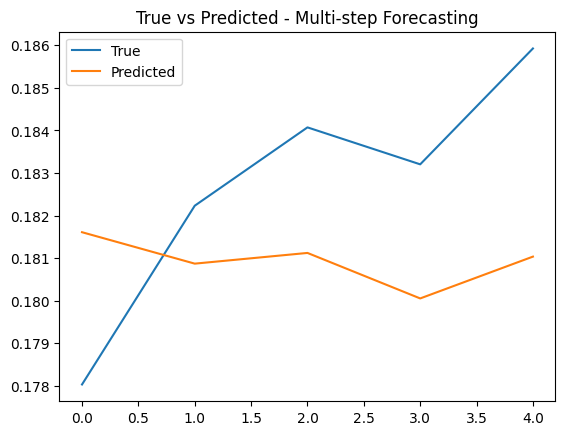

time: 122 ms (started: 2024-11-18 13:30:50 +00:00)


In [56]:
plt.plot(val_y[0], label='True')
plt.plot(y_pred[0], label='Predicted')
plt.legend()
plt.title('True vs Predicted - Multi-step Forecasting')
plt.show()

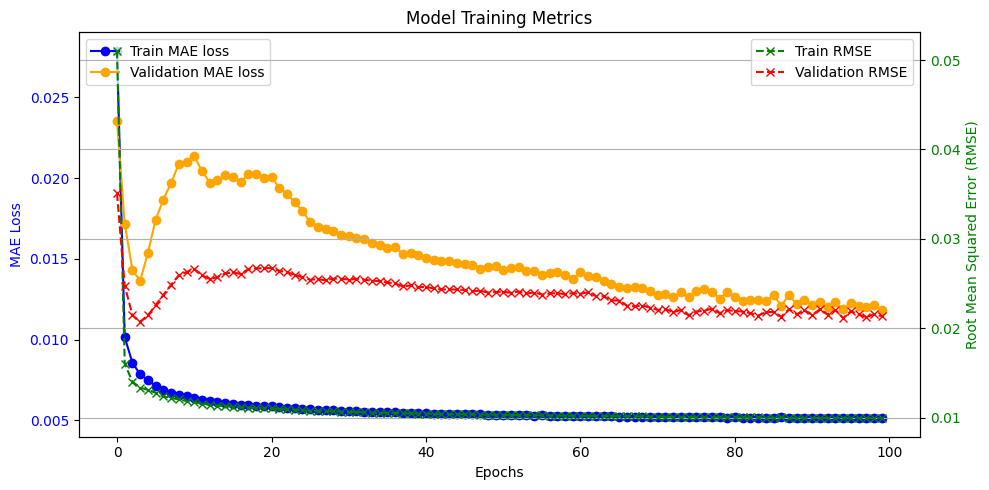

time: 196 ms (started: 2024-11-18 13:30:50 +00:00)


In [57]:
# Plotting
fig, ax1 = plt.subplots(figsize=(10, 5))

# Loss plot
N = len(history.history["loss"])
epoch_range = np.arange(0, N)

ax1.plot(epoch_range, history.history["loss"], label='Train MSE loss', marker='o', color='blue')
ax1.plot(epoch_range, history.history["val_loss"], label='Validation MSE loss', marker='o', color='orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MAE Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# RMSE plot (shared x-axis, different y-axis)
ax2 = ax1.twinx()
ax2.plot(epoch_range, history.history["rmse"], label='Train RMSE', marker='x', color='green', linestyle='--')
ax2.plot(epoch_range, history.history["val_rmse"], label='Validation RMSE', marker='x', color='red', linestyle='--')
ax2.set_ylabel('Root Mean Squared Error (RMSE)', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(loc='upper right')

plt.title('Model Training Metrics')
plt.grid()
plt.tight_layout()
plt.show()


Analyzing AAPL...

Evaluation Metrics for AAPL:
MSE: 39.3473
RMSE: 6.2727
MAE: 5.3181


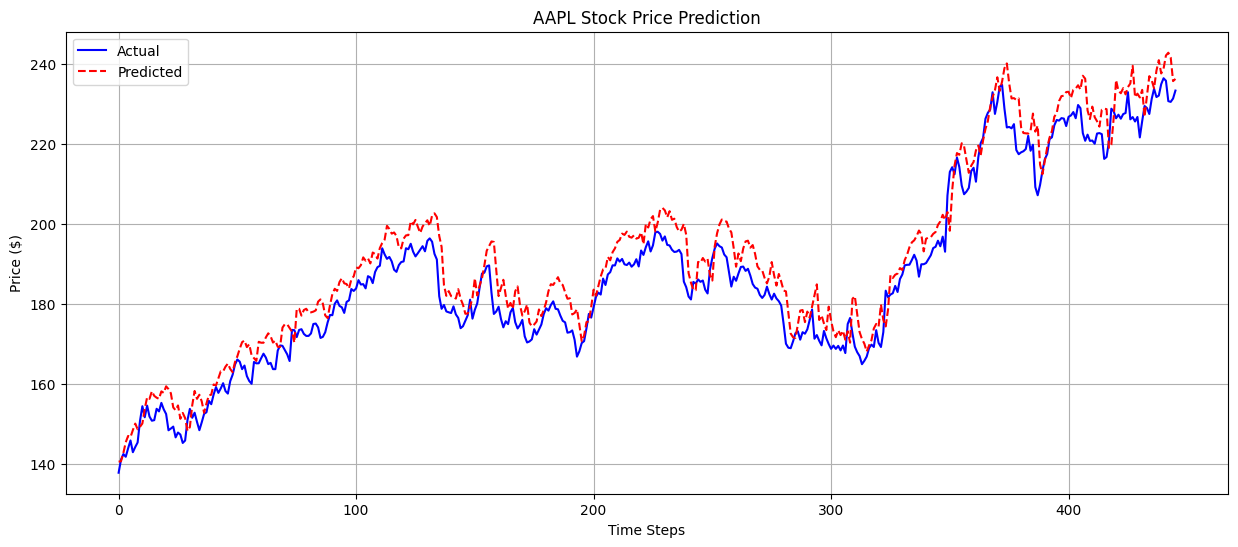


Analyzing AMZN...

Evaluation Metrics for AMZN:
MSE: 37.6083
RMSE: 6.1326
MAE: 5.0585


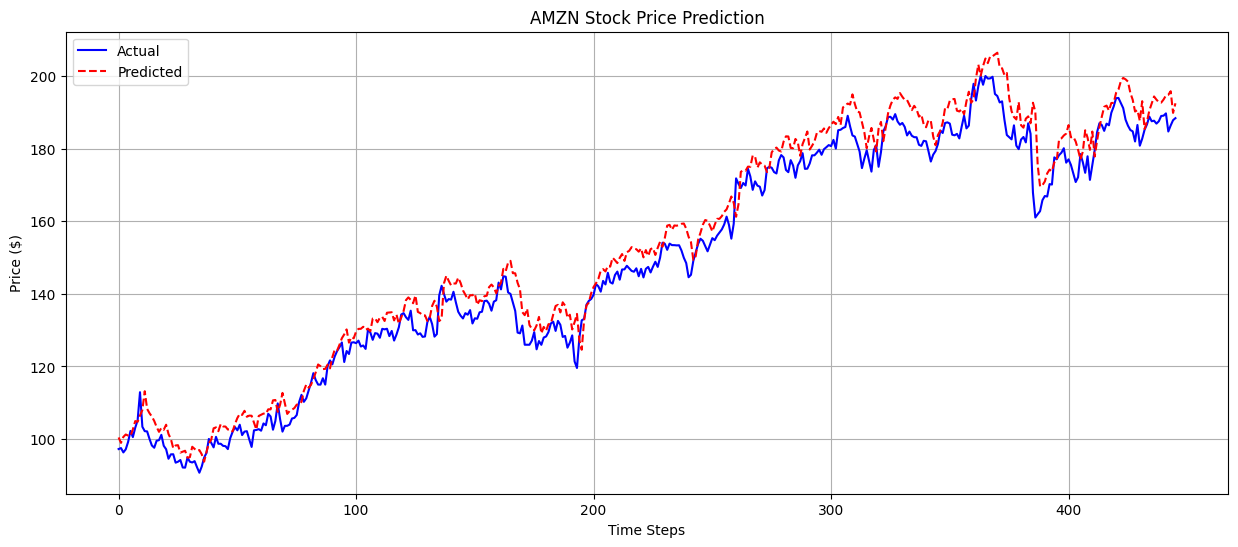


Analyzing GME...

Evaluation Metrics for GME:
MSE: 7.5371
RMSE: 2.7454
MAE: 1.5596


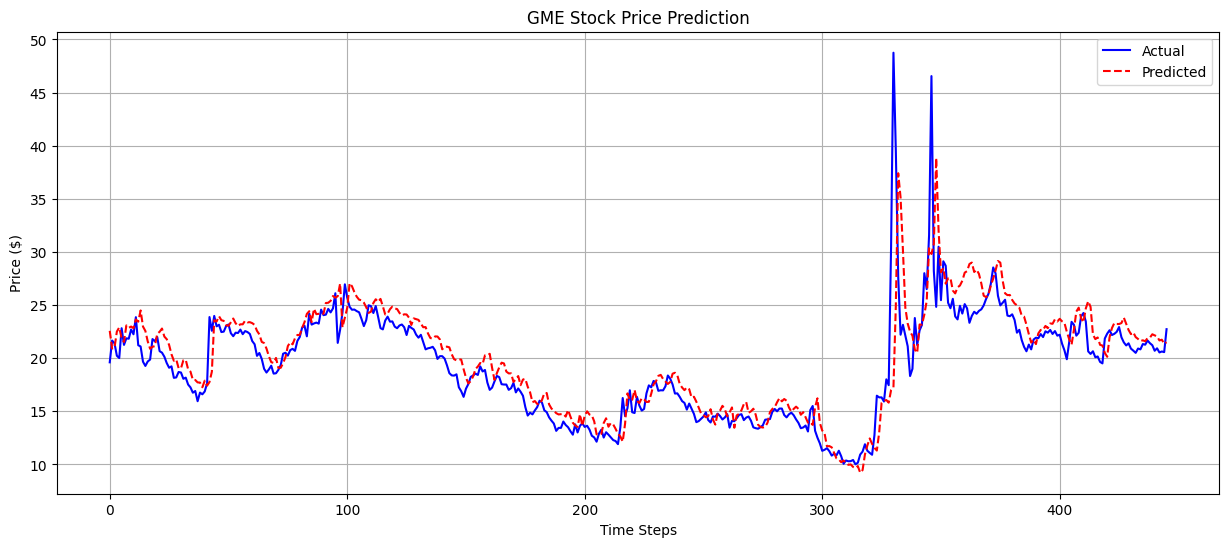


Analyzing GOOGL...

Evaluation Metrics for GOOGL:
MSE: 35.2144
RMSE: 5.9342
MAE: 4.9108


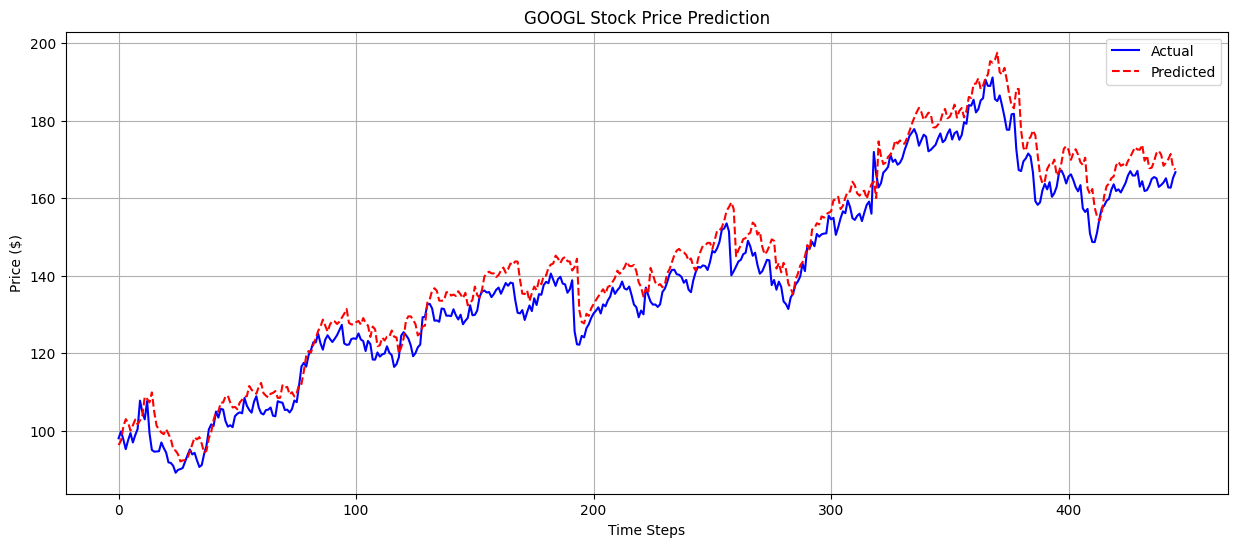


Analyzing NFLX...

Evaluation Metrics for NFLX:
MSE: 1310.5734
RMSE: 36.2018
MAE: 26.9279


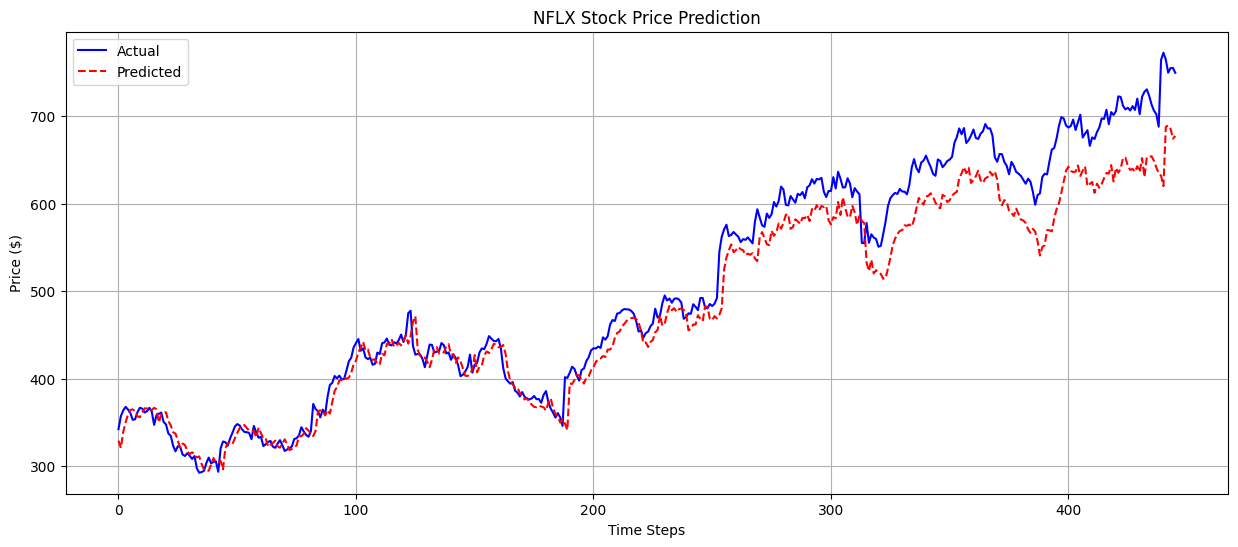


Analyzing TSLA...

Evaluation Metrics for TSLA:
MSE: 133.1057
RMSE: 11.5371
MAE: 8.7770


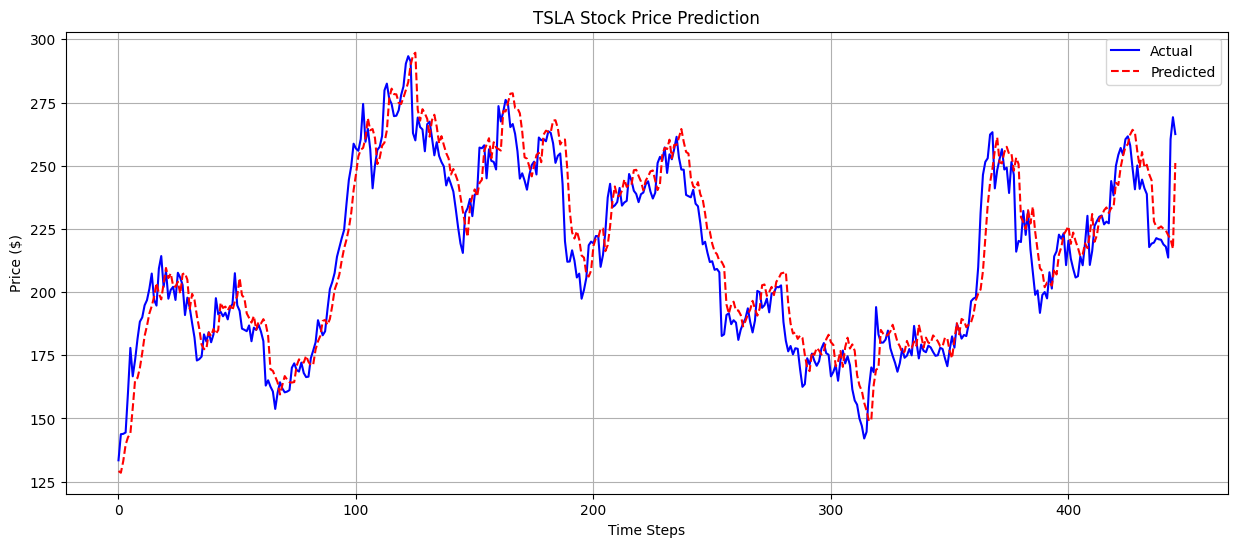


Analyzing MSFT...

Evaluation Metrics for MSFT:
MSE: 88.0554
RMSE: 9.3838
MAE: 7.4607


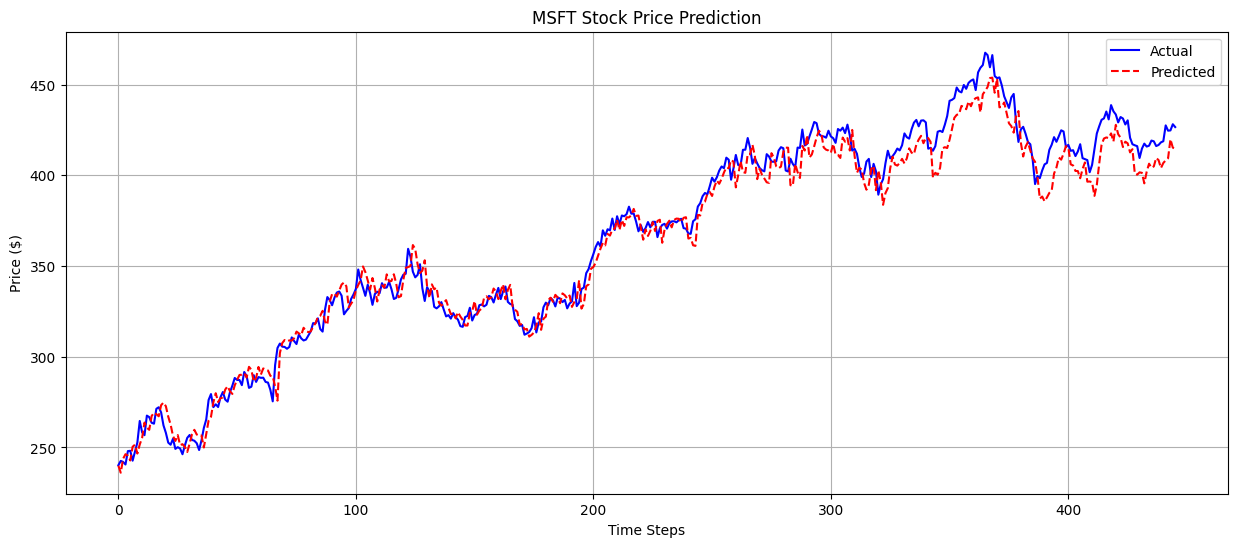


Analyzing NVDA...

Evaluation Metrics for NVDA:
MSE: 13.8739
RMSE: 3.7248
MAE: 2.4401


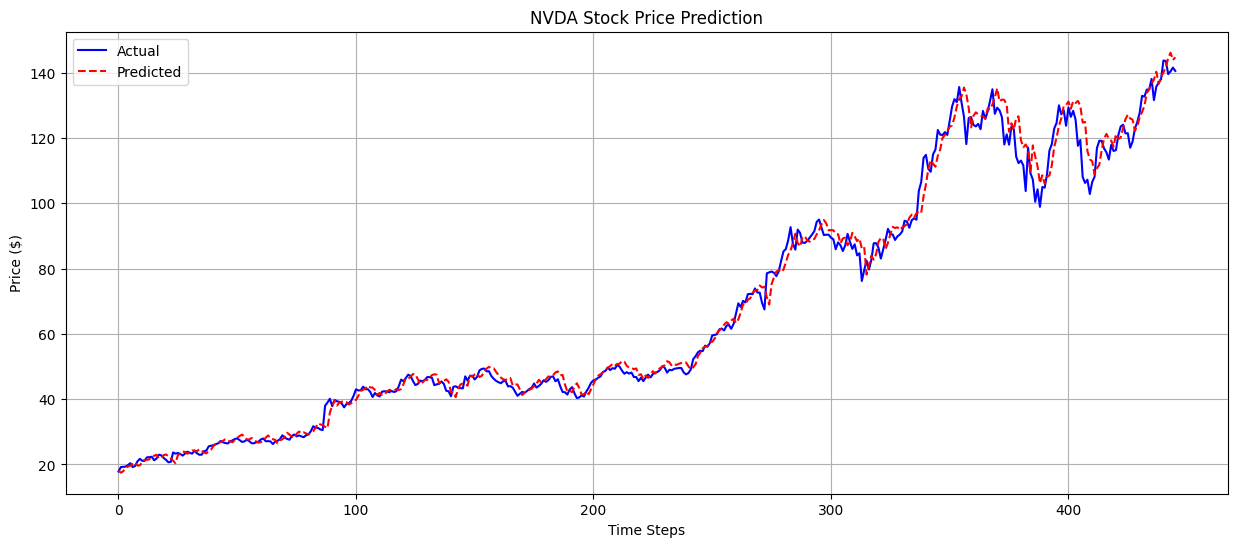


Analyzing AMD...

Evaluation Metrics for AMD:
MSE: 53.8866
RMSE: 7.3407
MAE: 5.7525


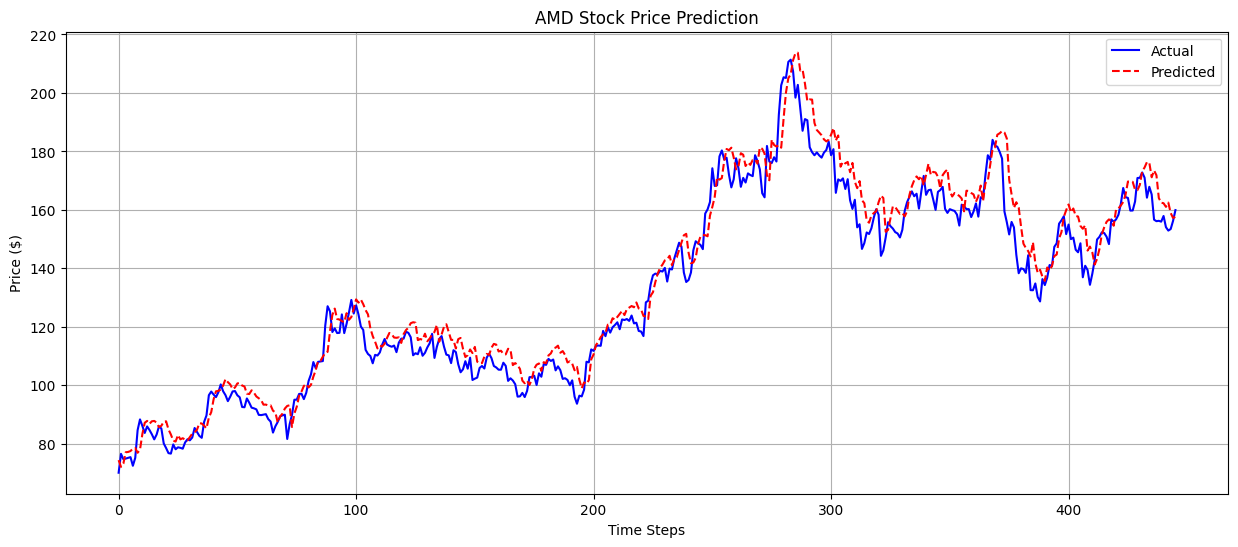


Analyzing CRM...

Evaluation Metrics for CRM:
MSE: 66.0901
RMSE: 8.1296
MAE: 6.1677


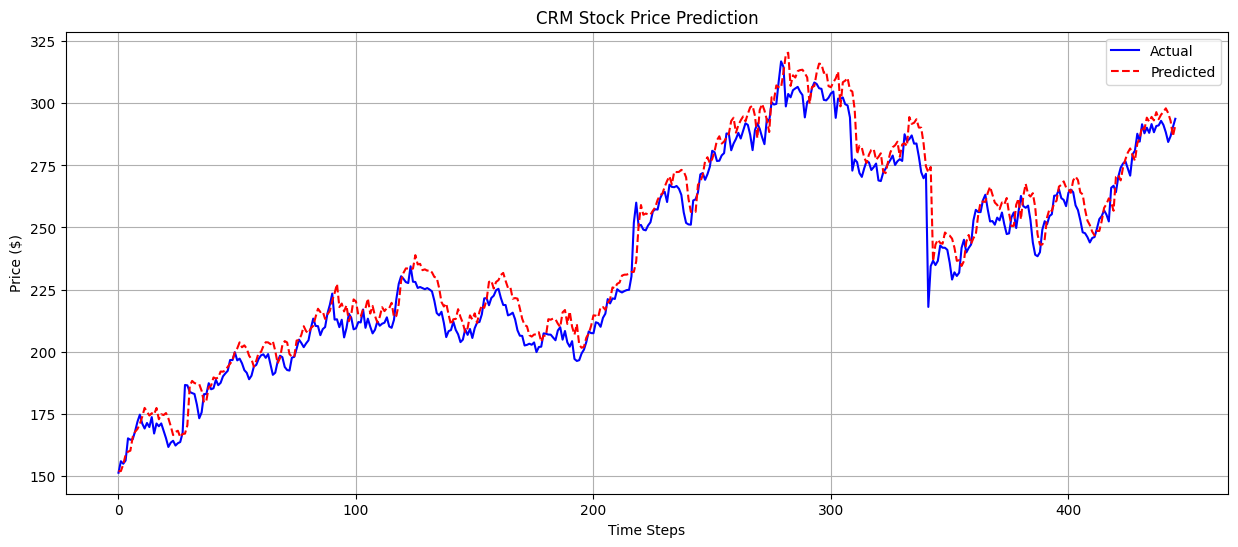


Analyzing JPM...

Evaluation Metrics for JPM:
MSE: 35.6884
RMSE: 5.9740
MAE: 5.1599


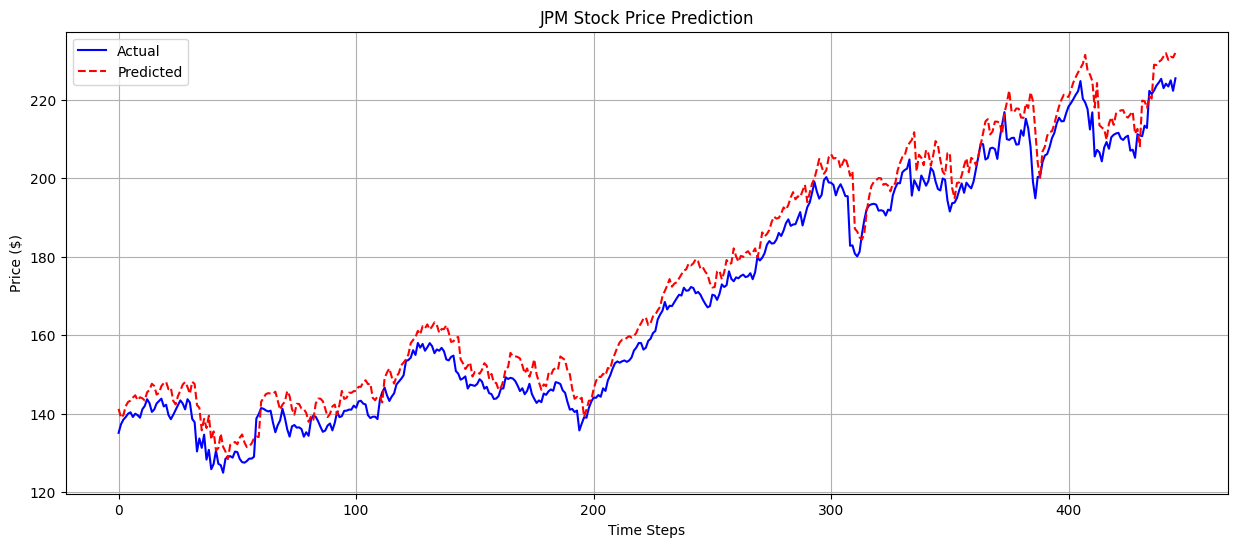


Analyzing V...

Evaluation Metrics for V:
MSE: 43.3566
RMSE: 6.5846
MAE: 5.5604


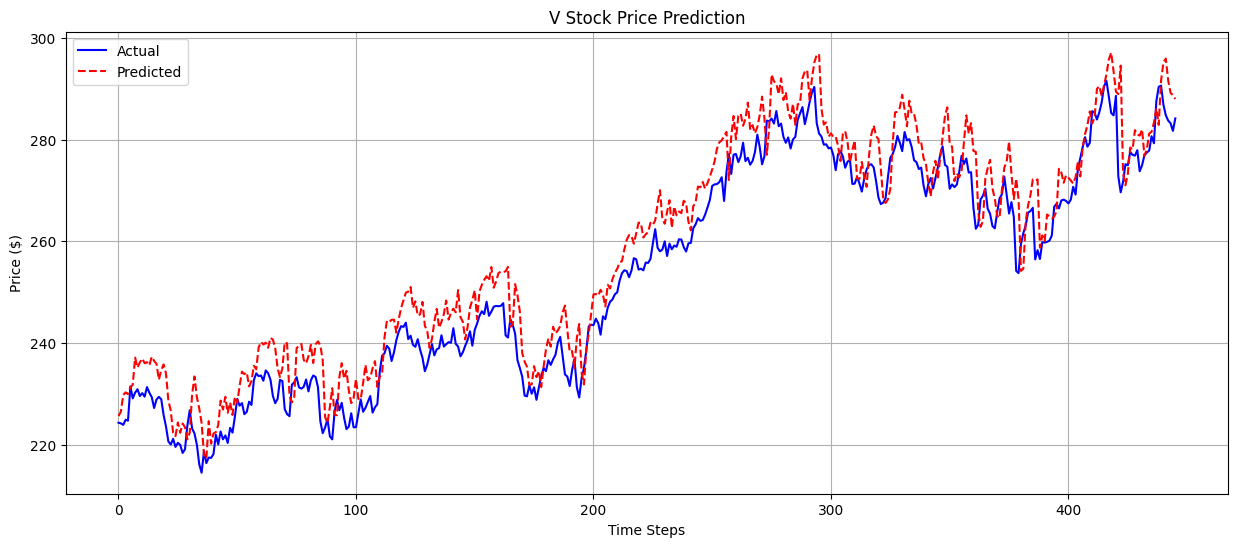


Analyzing MA...

Evaluation Metrics for MA:
MSE: 230.3931
RMSE: 15.1787
MAE: 12.8006


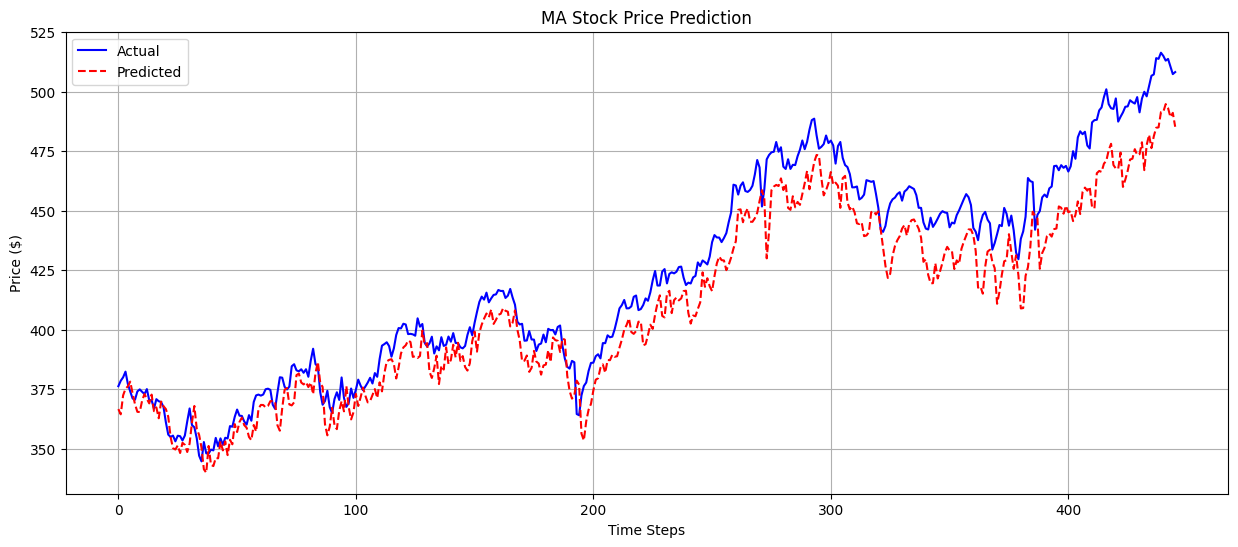


Analyzing MSTR...

Evaluation Metrics for MSTR:
MSE: 86.6829
RMSE: 9.3104
MAE: 5.9245


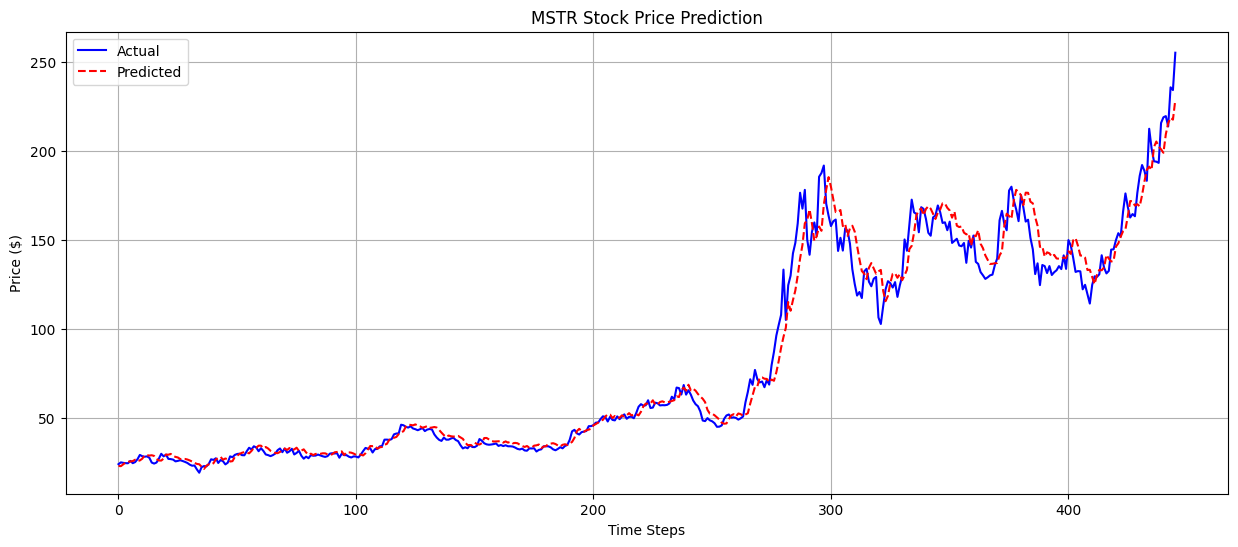


Analyzing DIS...

Evaluation Metrics for DIS:
MSE: 22.9064
RMSE: 4.7861
MAE: 4.2384


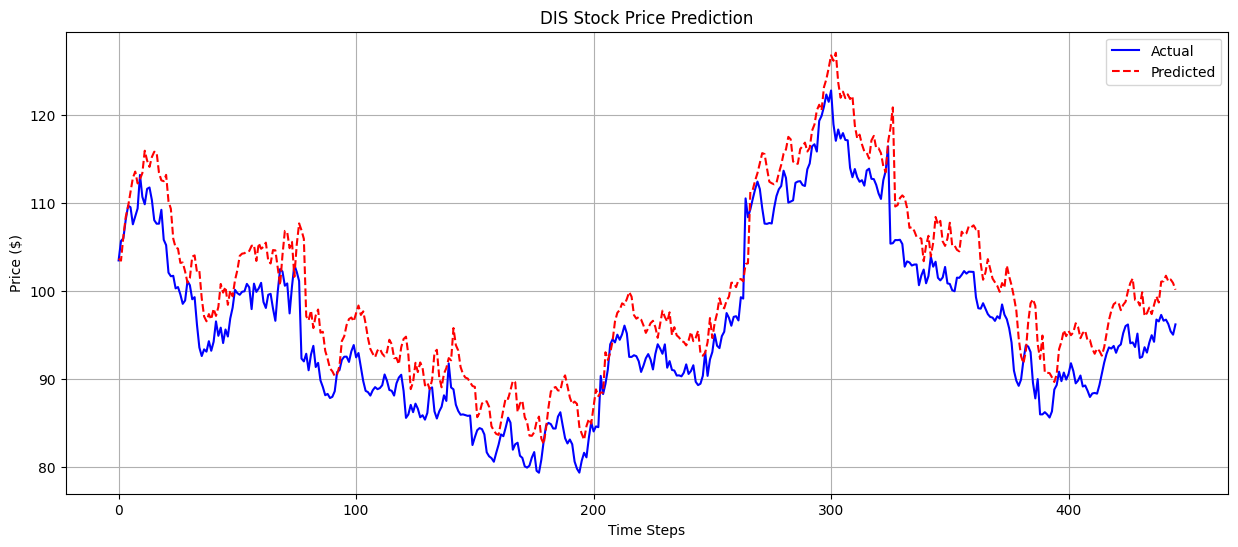


Analyzing BA...

Evaluation Metrics for BA:
MSE: 64.5324
RMSE: 8.0332
MAE: 6.5516


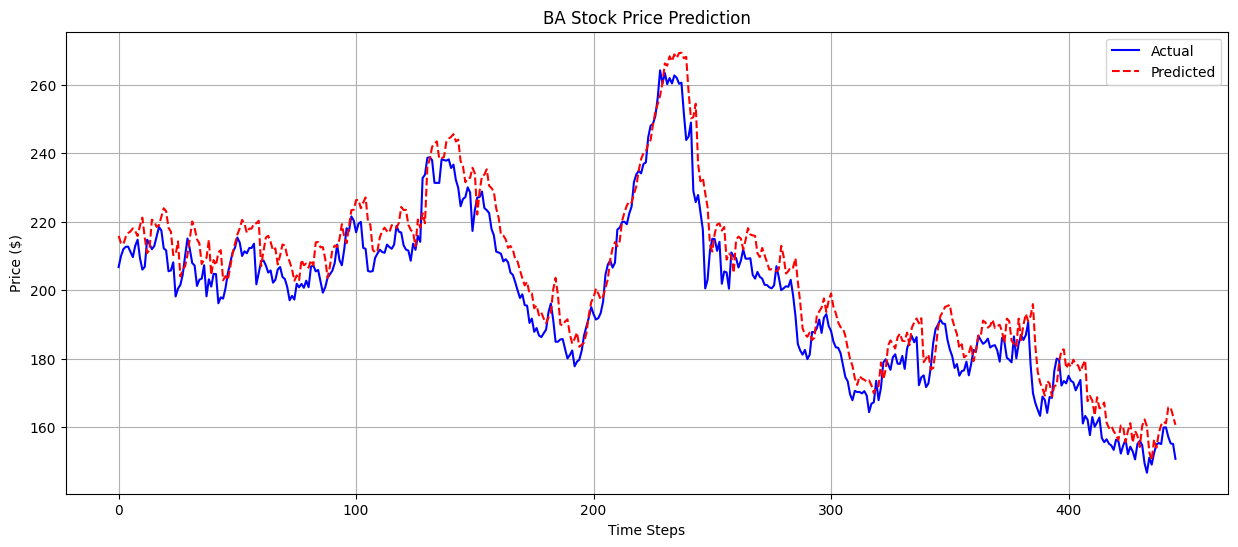


Analyzing XOM...

Evaluation Metrics for XOM:
MSE: 23.0473
RMSE: 4.8008
MAE: 4.2467


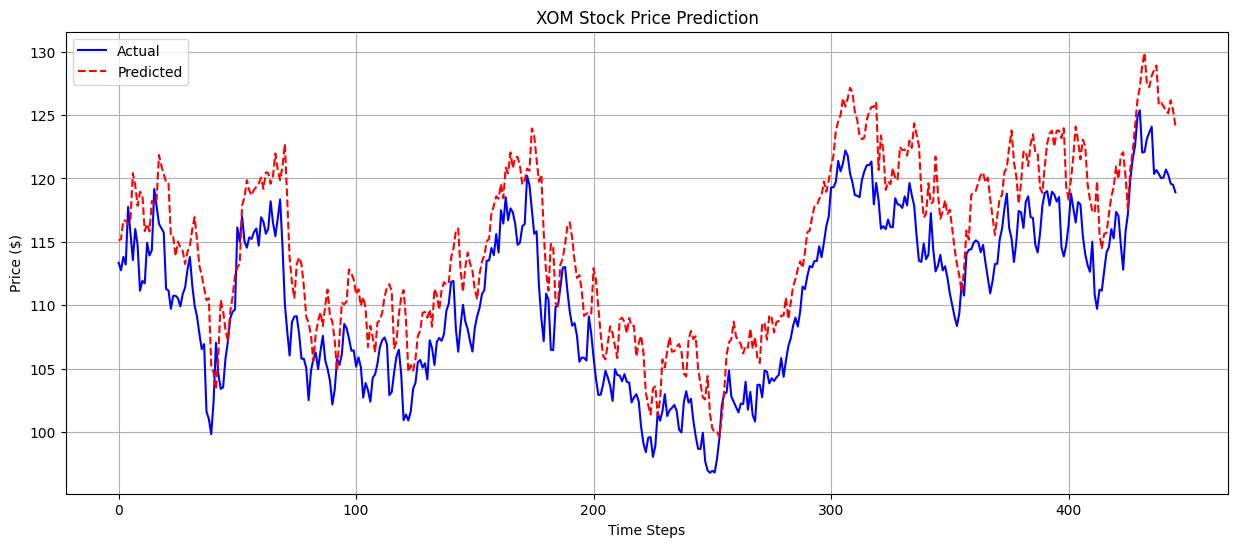


Analyzing ORCL...

Evaluation Metrics for ORCL:
MSE: 28.1661
RMSE: 5.3072
MAE: 4.5405


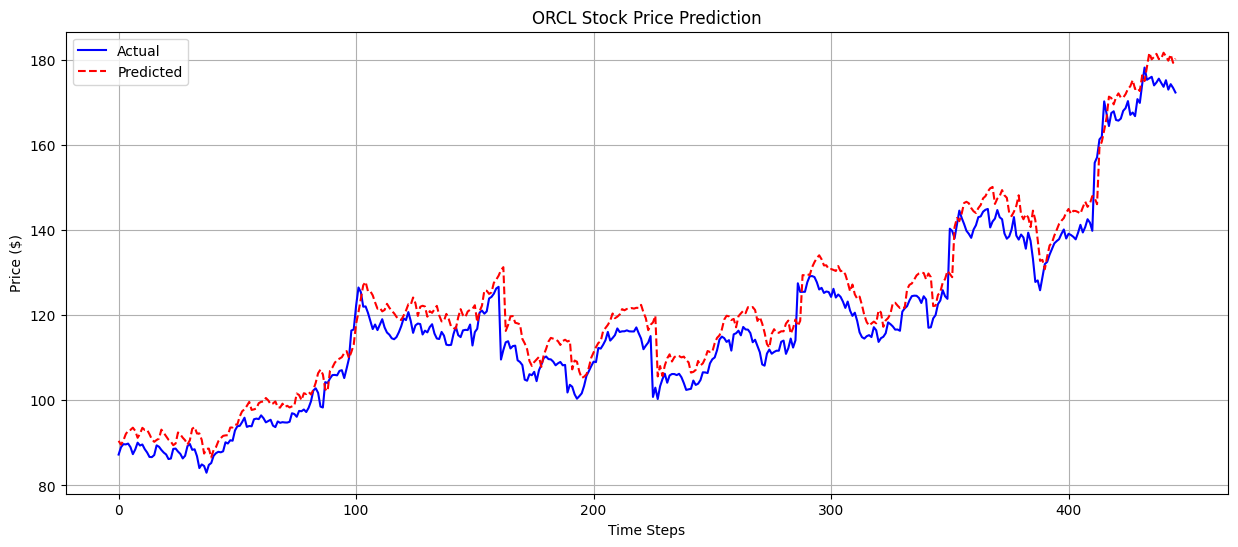


Analyzing META...

Evaluation Metrics for META:
MSE: 249.8371
RMSE: 15.8062
MAE: 11.4924


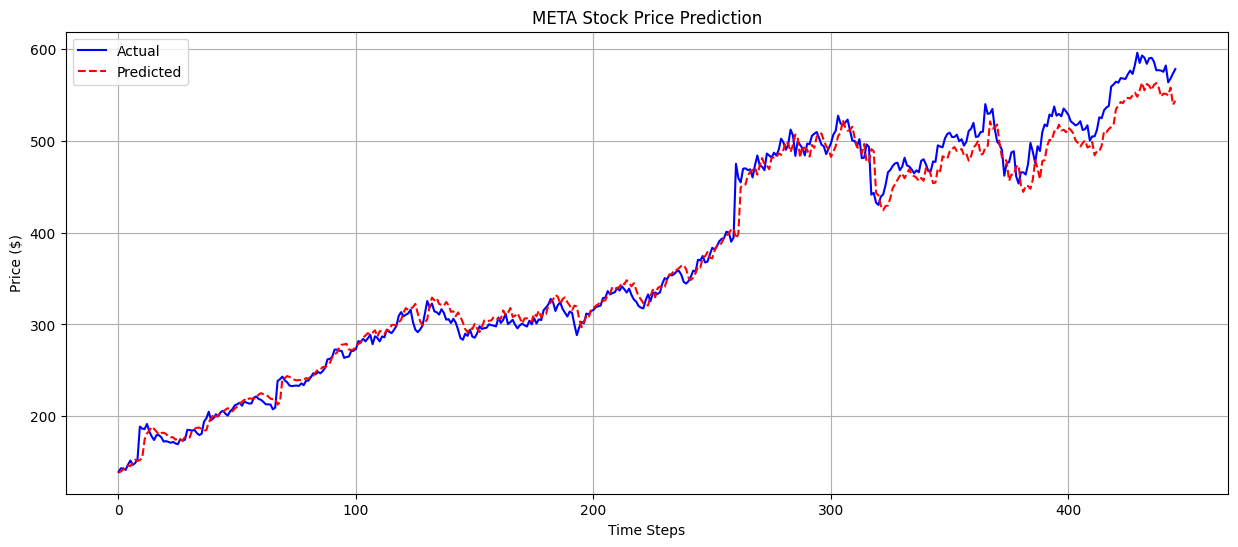


Summary of Metrics for All Stocks:
               MSE       RMSE        MAE
AAPL     39.347338   6.272746   5.318109
AMZN     37.608303   6.132561   5.058472
GME       7.537116   2.745381   1.559557
GOOGL    35.214380   5.934171   4.910829
NFLX   1310.573435  36.201843  26.927882
TSLA    133.105687  11.537144   8.776988
MSFT     88.055382   9.383783   7.460689
NVDA     13.873947   3.724775   2.440066
AMD      53.886584   7.340748   5.752545
CRM      66.090083   8.129581   6.167739
JPM      35.688389   5.973976   5.159894
V        43.356619   6.584574   5.560369
MA      230.393055  15.178704  12.800561
MSTR     86.682894   9.310365   5.924549
DIS      22.906367   4.786060   4.238371
BA       64.532408   8.033207   6.551577
XOM      23.047297   4.800760   4.246709
ORCL     28.166105   5.307175   4.540537
META    249.837127  15.806237  11.492372
time: 3.97 s (started: 2024-11-18 13:30:50 +00:00)


In [58]:
tickers = ['AAPL', 'AMZN', 'GME', 'GOOGL', 'NFLX', 'TSLA', 'MSFT', 'NVDA', 'AMD', 'CRM', 'JPM', 'V', 'MA', 'MSTR', 'DIS', 'BA', 'XOM', 'ORCL', 'META']

def split_validation_data(val_X, val_y, stock_lengths):
    """
    Split the combined validation data back into individual stocks.
    
    Args:
        val_X: Combined validation features
        val_y: Combined validation targets
        stock_lengths: List of number of validation samples for each stock
        
    Returns:
        tuple: Lists of validation X and y for each stock
    """
    val_X_stocks = []
    val_y_stocks = []
    
    start_idx = 0
    for length in stock_lengths:
        val_X_stocks.append(val_X[start_idx:start_idx + length])
        val_y_stocks.append(val_y[start_idx:start_idx + length])
        start_idx += length
        
    return val_X_stocks, val_y_stocks

def inverse_transform_price(scaled_data, scaler):
    """
    Convert scaled prices back to actual prices
    """
    # Create a dummy array with zeros for all features
    dummy = np.zeros((len(scaled_data), scaler.scale_.shape[0]))
    # Put the scaled prices in the correct column (-1 is close price next day)
    dummy[:, -1] = scaled_data
    # Inverse transform
    inverse_transformed = scaler.inverse_transform(dummy)
    # Return only the close price column
    return inverse_transformed[:, -1]

def evaluate_predictions(y_true, y_pred, ticker, scaler):
    """
    Calculate and print evaluation metrics for the predictions
    """
    # Convert scaled values back to actual prices
    y_true_actual = inverse_transform_price(y_true, scaler)
    y_pred_actual = inverse_transform_price(y_pred, scaler)
    
    # Calculate metrics on actual prices
    mse = mean_squared_error(y_true_actual, y_pred_actual)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_actual, y_pred_actual)
    
    print(f"\nEvaluation Metrics for {ticker}:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    
    return mse, rmse, mae

def plot_predictions(actual_values, predicted_values, ticker, scaler):
    """
    Plot actual vs predicted values in actual prices
    """
    plt.figure(figsize=(15, 6))
    
    # Convert to actual prices
    actual_prices = inverse_transform_price(actual_values, scaler)
    predicted_prices = inverse_transform_price(predicted_values, scaler)
    
    # Create time axis for plotting
    time_steps = range(len(actual_prices))
    
    # Plot
    plt.plot(time_steps, actual_prices, label='Actual', color='blue')
    plt.plot(time_steps, predicted_prices, label='Predicted', color='red', linestyle='--')
    
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Time Steps')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Calculate validation set lengths for each stock
def get_stock_val_lengths(values_list, train_split=0.8, n_steps_in=14, n_steps_out=5):
    """
    Calculate the number of validation samples for each stock
    """
    val_lengths = []
    for values in values_list:
        n_train = int(len(values) * train_split)
        val_data = values[n_train:]
        n_sequences = len(val_data) - n_steps_in - n_steps_out + 1
        if n_sequences > 0:
            val_lengths.append(n_sequences)
    return val_lengths

# Calculate validation lengths for each stock
val_lengths = get_stock_val_lengths(values_list)

# Split validation data back into individual stocks
val_X_stocks, val_y_stocks = split_validation_data(val_X, val_y, val_lengths)

# Make predictions for each stock
predictions_dict = {}
metrics_dict = {}

for i, ticker in enumerate(tickers):
    print(f"\nAnalyzing {ticker}...")
    
    # Get predictions for valid set
    val_predictions = model.predict(val_X_stocks[i], verbose=0)
    
    # Store predictions
    predictions_dict[ticker] = {
        'actual': val_y_stocks[i],
        'predicted': val_predictions
    }
    
    # Calculate metrics (using first day predictions)
    mse, rmse, mae = evaluate_predictions(
        val_y_stocks[i][:, 0],  # First day actual
        val_predictions[:, 0],   # First day predictions
        ticker,
        scaler
    )
    
    metrics_dict[ticker] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    }
    
    # Plot predictions (first day)
    plot_predictions(
        val_y_stocks[i][:, 0],    # First day actual
        val_predictions[:, 0],     # First day predictions
        ticker,
        scaler
    )

# Create a summary DataFrame of metrics
metrics_df = pd.DataFrame(metrics_dict).T
print("\nSummary of Metrics for All Stocks:")
print(metrics_df)

In [59]:
def plot_future_predictions(historical_data, future_preds, actual_prices, ticker, scaler):
    """
    Plot historical data, future predictions, and actual prices in different colors
    
    Parameters:
    - historical_data: Historical price data
    - future_preds: Model's price predictions
    - actual_prices: Actual prices for the prediction period
    - ticker: Stock ticker symbol
    - scaler: The scaler used to transform the data
    """
    plt.figure(figsize=(15, 6))
    
    # Convert to actual prices
    historical_prices = inverse_transform_price(historical_data, scaler)
    future_prices = inverse_transform_price(future_preds.flatten(), scaler)
    actual_future_prices = inverse_transform_price(actual_prices.flatten(), scaler)
    
    # Plot historical data
    plt.plot(range(len(historical_prices)), historical_prices, label='Historical', color='blue')
    
    # Plot predictions
    connection_indices = range(len(historical_prices)-1, len(historical_prices) + len(future_prices))
    connection_points = np.concatenate([historical_prices[-1:], future_prices])
    plt.plot(connection_indices, connection_points, label='Predicted', color='red', linestyle='--')
    
    # Plot actual future prices (starting from the last historical point)
    actual_indices = range(len(historical_prices)-1, len(historical_prices) + len(actual_future_prices))
    actual_points = np.concatenate([historical_prices[-1:], actual_future_prices])
    plt.plot(actual_indices, actual_points, label='Actual', color='green', linewidth=2)
    
    plt.title(f'{ticker} Stock Price - Prediction vs Actual')
    plt.xlabel('Time Steps')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()


def predict_future(model, last_sequence, n_steps_out, n_features):
    """
    Make future predictions using the last known sequence
    
    Args:
        model: trained LSTM model
        last_sequence: last known sequence of data (shape: [n_steps_in, n_features])
        n_steps_out: number of future steps to predict
        n_features: number of features in the input data
    """
    future_predictions = []
    current_sequence = last_sequence.reshape(1, n_steps_in, n_features)
    
    for _ in range(n_steps_out):
        # Get prediction for next step
        next_pred = model.predict(current_sequence, verbose=0)
        future_predictions.append(next_pred[0])
        
        # Update the sequence by removing the first timestep and adding the prediction
        # We'll repeat the last prediction across all features as an approximation
        new_row = np.repeat(next_pred[0][0], n_features).reshape(1, 1, n_features)
        current_sequence = np.concatenate([current_sequence[:, 1:, :], new_row], axis=1)
    
    return np.array(future_predictions)

# Future predictions
print("\nMaking Future Predictions...")
n_features = train_X.shape[2]

for i, ticker in enumerate(tickers):
    print(f"\nPredicting future prices for {ticker}...")
    
    # Get the last sequence from the validation data
    last_sequence = val_X[i][-1]
    
    # Make future predictions
    future_preds = predict_future(model, last_sequence, n_steps_out, n_features)
    
    # Get recent historical data for plotting (last 30 days)
    historical_data = val_y[i][-30:, 0]
    
    # Get actual future prices for comparison (next n_steps_out days)
    actual_future_prices = val_y[i][-n_steps_out:]
    
    # Print actual price predictions
    future_prices = inverse_transform_price(future_preds.flatten(), global_scaler)
    print(f"\n{ticker} - Next {n_steps_out} days price predictions:")
    for day, price in enumerate(future_prices, 1):
        print(f"Day {day}: ${price:.2f}")
        
    # Print actual prices for comparison
    actual_prices = inverse_transform_price(actual_future_prices.flatten(), global_scaler)
    print(f"\n{ticker} - Actual prices for comparison:")
    for day, price in enumerate(actual_prices, 1):
        print(f"Day {day}: ${price:.2f}")
        
    # Plot future predictions with historical context and actual prices
    try:
        plot_future_predictions(historical_data,future_preds,actual_future_prices,ticker,global_scaler)
    except Exception as e:
        print(f"Error plotting predictions for {ticker}: {e}")
        continue



Making Future Predictions...

Predicting future prices for AAPL...


ValueError: cannot reshape array of size 20 into shape (1,14,20)

time: 30.7 ms (started: 2024-11-18 13:30:54 +00:00)
